In [1]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#import plotly.graph_objs as go
%matplotlib inline

In [2]:
from pandas_datareader import data as pdr

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
days_to_extract = 1000
days_to_forecast = 20

In [4]:
date_end = dt.date.today()
date_start = date_end - dt.timedelta(days_to_extract)

In [5]:
date_end, date_start

(datetime.date(2020, 7, 1), datetime.date(2017, 10, 5))

In [6]:
df = pdr.DataReader("AAPL", 'yahoo', date_start, date_end).reset_index()

df = df.loc[df['Date'].notnull()]

In [7]:
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-10-05,155.440002,154.050003,154.179993,155.389999,21283800.0,149.524597
1,2017-10-06,155.490005,154.559998,154.970001,155.300003,17407600.0,149.437988
2,2017-10-09,156.729996,155.490005,155.809998,155.839996,16262900.0,149.957611
3,2017-10-10,158.000000,155.100006,156.059998,155.899994,15617000.0,150.015335
4,2017-10-11,156.979996,155.750000,155.970001,156.550003,16905600.0,150.640839
...,...,...,...,...,...,...,...
683,2020-06-24,368.790009,358.519989,365.000000,360.059998,48155800.0,360.059998
684,2020-06-25,365.000000,357.570007,360.700012,364.839996,34380600.0,364.839996
685,2020-06-26,365.320007,353.019989,364.410004,353.630005,51314200.0,353.630005
686,2020-06-29,362.170013,351.279999,353.250000,361.779999,32661500.0,361.779999


In [8]:
df.dtypes

Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

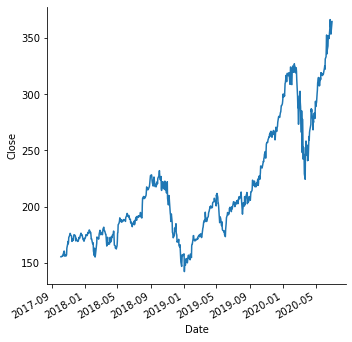

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(x='Date', y='Close', kind='line', data=df).fig.autofmt_xdate()

# preprocessing

In [10]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
le = preprocessing.LabelEncoder()

In [11]:
df['Date encoded'] = le.fit_transform(df['Date'])

In [12]:
days_cutoff = len(df) - days_to_forecast

In [13]:
scaled_Close = scaler.fit_transform(df[['Close']])

In [14]:
scaled_Close = np.squeeze(scaled_Close)

In [15]:
df.values[days_cutoff:, 7]

array([668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680,
       681, 682, 683, 684, 685, 686, 687], dtype=object)

In [16]:
x_train, y_train = df.values[:days_cutoff, 7], scaled_Close[:days_cutoff]
x_test, y_test = df.values[days_cutoff:, 7], scaled_Close[days_cutoff:]

x_train, y_train = df.values[:600, 0], scaled_Close[:600]
x_test, y_test = df.values[600:, 0], scaled_Close[600:]

In [17]:
x_train.shape, x_test.shape

((668,), (20,))

# split train data

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=.2)


## statsmodels

In [20]:
data = df.set_index('Date')

In [21]:
#import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import plotly.graph_objects as go

In [22]:
decomposition = seasonal_decompose(data.Close, model='additive', period=200)

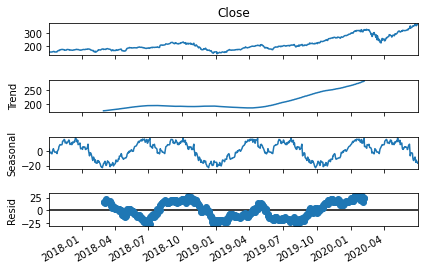

In [27]:
decomposition.plot().autofmt_xdate()

In [ ]:
gtrace = go.Scatter( x= df.Date, y=decomposition.observed, name='observed')

In [ ]:
gtrace

# Reshape data in order to apply LSTML

x_train.shape, y_train.shape, x_test.shape, y_test.shape


X_train_t = x_train.reshape(x_train.shape[0], 1, 1)
X_test_t = x_test.reshape(x_test.shape[0], 1, 1)

X_test_t.shape, X_train_t.shape

## Keras

from keras.models import Sequential
from keras.layers import Dense

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
import keras.backend as K 
from keras.callbacks import EarlyStopping
#import lstm, time

model = Sequential()

#model.add(Dense(50, activation='sigmoid', input_shape=(1,)))
#model.add(LSTM(30, activation='sigmoid', input_shape=(None,1)))

model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(None,1))) #rectified linear unit
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))

model.summary()

model.compile(optimizer='rmsprop', loss='mse', metrics=['mape']) 
#optimizer = 'adgrad', 'adam', 'sgd', 'rmsprop'
#sgd - stochastic gradient descent
#mse - mean square error
#mape - mean absolute percentage error

#history = model.fit(x_train, y_train, batch_size=10, epochs=200, validation_data=(x_valid, y_valid))

early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=0, save_best_only=True, mode='auto')


history = model.fit(X_train_t, y_train, epochs=200, batch_size=10, verbose=1, callbacks=[early_stop])



for name, value in history.history.items():
    plt.plot(value, label=name)
plt.legend()
plt.show()

## evaluate model

#results = model.evaluate(x_test, y_test)

results = model.evaluate(X_test_t, y_test)
#print('Loss: {:.6f} - MAPE: {:.6f}'.format(*results))

trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

trainScore = model.evaluate(X_train_t, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(X_test_t, y_test, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(X_test_t, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

test_pred = model.predict(X_test_t)
train_pred = model.predict(X_train_t)
#train_pred = np.squeeze(train_pred)

plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, '.y', x_test, y_test, '.r',x_train, train_pred, '.b', x_test, test_pred, '.b')
plt.show()

plt.figure()
plt.plot(test_pred)

for pred, true in zip(test_pred, y_test):
    print('Pred: {:.6f} - True: {:.6f}'.format(pred,true))

Save model

model_path = 'model.lstm_drop'
model.save(model_path)

from keras.models import load_model

loaded_model = load_model(model_path)

loaded_model.summary()